In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, KFold
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

In [4]:
# load dHCP data
df = pd.read_csv('/neurospin/dico/rmenasria/Runs/03_main/Input/dHCP/csv/all_participants_infos.csv').loc[:, ['ID', 'birth_weight', 'birth_age']]
df_prema = df [df["birth_age"] < 37].copy()
X = df_prema[['birth_weight']].values   
y = df_prema['birth_age'].values        

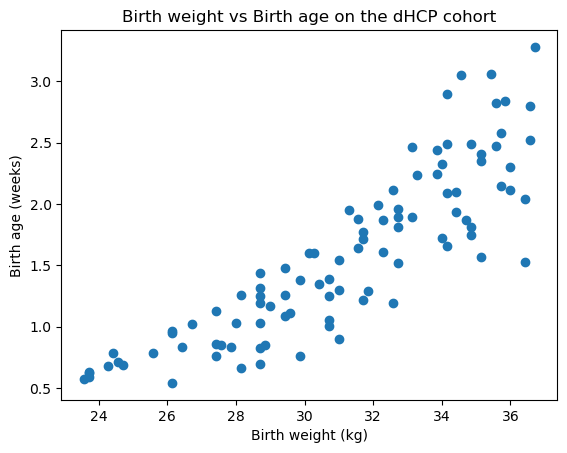

In [10]:
# Scatter plot of birth weight vs birth age
plt.figure()
plt.scatter(y,X)
plt.xlabel('Birth weight (kg)')
plt.ylabel('Birth age (weeks)')
plt.title('Birth weight vs Birth age on the dHCP cohort')
plt.show()

In [ ]:
# Build pipeline
pipe = Pipeline([
    ('poly', PolynomialFeatures()),
    ('scaler', StandardScaler()),      
    ('reg', LinearRegression())        
])

# Build the parameter grid
param_grid = {
    'poly__degree': [1, 2, 3]
}     

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# GridSearch
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=kf,
    n_jobs=-1
)

# Fit
grid.fit(X, y)

# Results
print("Best params :", grid.best_params_)
print("MAE (CV) :", -grid.best_score_)

# Print the cross-validation results
results = pd.DataFrame(grid.cv_results_)
results = results[['params', 'mean_test_score', 'std_test_score']]
results['mean_test_score'] = -results['mean_test_score']
results['std_test_score'] = -results['std_test_score']
results = results.sort_values(by='mean_test_score', ascending=False)
print("\n Cross val results :")


for index, row in results.iterrows():
    print(f"Parameters : {row['params']}, MAE (CV) : {row['mean_test_score']:.3f} ± {row['std_test_score']:.3f}")


# print the coefficients of the best model
best_model = grid.best_estimator_
print("\nBest model coefficients:")
print(f"Intercept: {best_model.named_steps['reg'].intercept_}")
print(f"Coefficients: {best_model.named_steps['reg'].coef_}")


intercept = grid.best_estimator_.named_steps['reg'].intercept_
coefs     = grid.best_estimator_.named_steps['reg'].coef_
joblib.dump(grid.best_estimator_, 'birth_age_regression_from_weight_model.pkl')


Best params : {'poly__degree': 3}
MAE (CV) : 1.148877798165368

 Cross val results :
Parameters : {'poly__degree': 1}, MAE (CV) : 1.577 ± -0.115
Parameters : {'poly__degree': 2}, MAE (CV) : 1.149 ± -0.069
Parameters : {'poly__degree': 3}, MAE (CV) : 1.149 ± -0.077

Best model coefficients:
Intercept: 37.733002291443846
Coefficients: [ 0.          7.80492871 -0.72545693 -3.31835352]


['birth_age_regression_from_weight_model.pkl']